In [2]:
import os
import time

import re
import copy
import numpy as np
import pandas as pd
import h5py
import tables
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import rioxarray as rxr
import math
import pickle
from pickle import dump
import sklearn
import graphviz
import xgboost as xgb
import lightgbm as lgbm
from platform import python_version

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance as plot_importance_XGB
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as plot_importance_LGBM

print(pd.__version__) # should be 1.3.0
print(sklearn.__version__) # should be 0.24.1
print(python_version()) 

1.3.5
1.0.2
3.9.5


In [3]:
os.getcwd()
os.chdir('..')
os.getcwd()
os.chdir('..')

'/uufs/chpc.utah.edu/common/home/civil-group1/ItalianAlps/SnowCast/Final_Model/Model'

In [106]:
### load regionalized geospatial data

### define regions
Region_list = ['N_Sierras',
               'S_Sierras_High',
               'S_Sierras_Low',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]

### Load H5 train files into dictionary
RegionTrain= {}
for region in Region_list:
    RegionTrain[region] = pd.read_hdf('Data/Model_Calibration_Data/RegionTrain_Final.h5', region)
    

###### Framework for a universal GB model class

In [112]:
Region_list = ['N_Sierras',
               'S_Sierras_High',
               'S_Sierras_Low',
               'Greater_Yellowstone',
               'N_Co_Rockies',
               'SW_Mont',
               'SW_Co_Rockies',
               'GBasin',
               'N_Wasatch',
               'N_Cascade',
               'S_Wasatch',
               'SW_Mtns',
               'E_WA_N_Id_W_Mont',
               'S_Wyoming',
               'SE_Co_Rockies',
               'Sawtooth',
               'Ca_Coast',
               'E_Or',
               'N_Yellowstone',
               'S_Cascade',
               'Wa_Coast',
               'Greater_Glacier',
               'Or_Coast'
              ]

In [113]:
### hyperparameter grid

LGBM_param_grid = {
    "max_depth": list(range(3,30,4)),
    "num_leaves": list(range(5,55,10)),
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "n_estimators": list(range(300,700,100))  
}


In [114]:
class REGRESSOR(object):
    """
    Regression optimization model class.
    Args:
        target (str): target to be modeled.
        data (dict): Dictionary of dataframes containing training/testing data
        estimator (model object): type of model to be fit.
        param_grid (dict): hyperparameter grid
        model (fit XGBRegressor, LGBMRegessor, etc..): the fit model object
    """

    def __init__(self, target, data, estimator=None, param_grid=None, model=None):
        self.target = target
        self.data = data
        self.estimator = estimator 
        self.param_grid = param_grid
        self.model = model
        self.param_grid2 = param_grid
    
    @staticmethod
    def make_dataframe(region, data):
        """Dataframe manipulation."""
        
        df = data.get(region)
        
        ### replace -9999s with nans
        df=df.replace([-9999, -9999.99], np.nan)     
        
        ### create new index 0 - len(df)
        df= df.reset_index(drop=False)
        df =df.rename(columns={"index": "cell_id"})
        if 'Date' in df.columns:
            df = df.drop(columns=['Date']) 
        
        ###create indexed series of cell ids
        id_map = df.pop('cell_id').to_frame()
        id_map['Long'] = df['Long']
        id_map['Lat'] = df['Lat']
        id_map['WYWeek'] = df['WYWeek']
        id_map['elevation_m'] = df['elevation_m']

        ### shuffle dataframe
        df = df.sample(frac=1, random_state=1234)
        
        ### replace special character ':' with '__' 
        df = df.rename(columns = lambda x:re.sub(':', '__', x))
        
        return df, id_map

    def fit_(self, region, cv=5):
        """Gridsearch for Parmas, Fit model, and save as instance attribute."""
        start_time = time.time()

        ### Dataframe engineering step
        df, id_map = self.make_dataframe(region, self.data)

        y = df.pop(self.target)

 
        ###normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(df)
        df = pd.DataFrame(scaled, columns = df.columns)
        #save scaler data here
        pickle.dump(scaler, open(os.getcwd()+'/Model/Model_Calibration/Prev_LGBM/Scalers/'+'LGBM_'+region+'_scaler.pkl', 'wb'))
        
        X = df
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)


        ### Fit CV to define optimal hyperparmaeters
        gs = GridSearchCV(
            self.estimator(),
            self.param_grid,
            cv=5,
            n_jobs=-1,
            return_train_score=True,
            refit=False
        )

        gs.fit(X_train, y_train)

        self.best_score = gs.best_score_
        self.param_grid = gs.best_params_
        print('Best Score:', gs.best_score_)
        print('Best Params:', gs.best_params_)


        ### Fit the estimator model with the optimal params
        self.model = self.estimator(**self.param_grid)

        X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = self.Feature_selection(X_train, X_test, y_train, y_test)
        
        c_time = round(time.time() - start_time,2)
        print('Calibration time', round(c_time), 's')
        
        return X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe, id_map
    
    def Feature_selection(self, X_train, X_test, y_train, y_test):
        """Identify and and fit model with optimal features """
        ### Define RFE with CV model
        min_features_to_select = 1  # Minimum number of features to consider
        rfecv = RFECV(
            estimator=self.model,
            step=1,
            cv=5,
            n_jobs=-1,
            min_features_to_select=min_features_to_select,
        )
        
        rfecv.fit(X_train, y_train)

        ### dataframe of optimal features, remove non-optimal features from train/test data 
        feat = {'Features_raw': X_train.columns}
        RFECV_Feat = pd.DataFrame(data=feat)
        RFECV_Feat['Rank']= rfecv.ranking_
        RFECV_Feat['Selected']= rfecv.support_
        RFECV_Feat_opt = RFECV_Feat[RFECV_Feat['Selected']==True]
        RFECV_Feat_opt = RFECV_Feat_opt['Features_raw']
        RFECV_Feat_opt.columns=['Features_opt']
        print('The optimal features are: ', list(RFECV_Feat_opt))
        ### use optimal features for final fit data
        X_train=X_train[list(RFECV_Feat_opt)]
        X_test=X_test[list(RFECV_Feat_opt)]
        
        ### fit model with optimal parmas & optimal # of featuress
        self.model = self.estimator(**self.param_grid)
        self.model.fit(X_train, y_train)
        
        
        ### Plot number of features vs. cross-validation scores
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score (accuracy)")
        plt.plot(range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
            rfecv.cv_results_["mean_test_score"])
        plt.show()

        print("Optimal number of features : %d" % rfecv.n_features_)

        ### Revert special character '__' with ':'
        X_train = X_train.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        X_test = X_test.rename(columns = lambda x:re.sub(r"(_)\1+", ':', x))
        
        return X_train, X_test, y_train, y_test
    
    
    def predict_(self, X_test):
        """Generate model predictions."""

        preds = (self.model.predict(X_test))
        
        ### correct negative predictions
        preds[preds <0]=0
        
        return preds



In [115]:
def Batch_Train(target, data, algorithm, parameter_grid, Region_list):
    """
    Batch train regression model and produce testing prediction.
    Args:
        algorithm (model object): Regressor to be fit (XGBRegressor, LGBMRgressor)
        param_grid (dict): Hyperparameter grid
        Region_list (list): List of regions to be evaluated
        models_dierctory (str): Root path of the dierctory to save models (ie. "Models/XGB")
        dictionary_directory (str): Root path of the dierctory to save output dictionaries (ie. "Models/XGB")
    """
    
    split_dict={}
    prediction_dict={}
    features_dict = {}
    ### define prefix for path based on algorithm desired
    if algorithm == XGBRegressor:
        path_name = 'XGB'
        from xgboost import plot_importance
    elif algorithm == LGBMRegressor:
        path_name = 'LGBM'
        from lightgbm import plot_importance
    else:
        raise ValueError("Algorithm not recognized. Must be XGBRegressor or LGBMRegressor.")
    
    for region in Region_list:
        ###Instantiate Model
        region_model = REGRESSOR(target=target, data=data, estimator=algorithm, param_grid=parameter_grid)
        
        ###Fit region model and add dictionary entry for region test-train data, save fit model to file.
        ###Dictformat is, split_dict{'region': [X_train, X_test, y_train, y_test, cell_id]}
        print(region,':')
        split_dict[region] = region_model.fit_(region)
        print('Saving Model')
        pickle.dump(region_model, open(os.getcwd()+"/Model/Model_Calibration/Prev_LGBM/LGBM_"+region+".pkl", "wb"))
        
        ###Generate predictions and add to prediction dictionary,
        ###Dict format is, prediction_dict{'region': [preds]}
        prediction_dict[region] = region_model.predict_(split_dict.get(region)[1])
        
        ### plot predictions
        fig, ax =plt.subplots()
        sns.set(style="whitegrid")
        plt.scatter(split_dict.get(region)[3], prediction_dict.get(region), marker='.',s=100, color = 'b')
        plt.plot([0,(prediction_dict.get(region).max()+10)], [0,(prediction_dict.get(region).max()+10)], ls="--", c=".1")
        plt.xlim([0, (split_dict.get(region)[3].max()+5)])
        plt.ylim([(prediction_dict.get(region).min()-1),(prediction_dict.get(region).max()+5)])
        ax.set_title(region)
        ax.set_xlabel("Truth")
        ax.set_ylabel("Prediction")
        plt.show()
        rmse = mean_squared_error(split_dict.get(region)[3], prediction_dict.get(region), squared=False)
        print(region, "RMSE:", (round(rmse,3)))
        
        ###Optimal Features dictionary 
        features_dict[region] = split_dict[region][0].columns

        
    ###Save output dictionaries to file
    pickle.dump(split_dict, open(os.getcwd()+"/Model/Model_Calibration/Prev_LGBM/Output/"+path_name+"_split_dict_final.pkl", "wb"))
    pickle.dump(prediction_dict, open(os.getcwd()+"/Model/Model_Calibration/Prev_LGBM/Output/"+path_name+"_prediction_dict_final.pkl", "wb"))
    pickle.dump(features_dict, open(os.getcwd()+"/Model/Model_Calibration/Prev_LGBM/Output/opt_features_final.pkl", "wb"))
    
    return split_dict, prediction_dict



def Make_Prediction(model_folder_ext,Region_list, Eval_set):
    """
    Run regression model for defined region to output dataframe of predictions 
    for all cell id sites across all regions. 
    Args:
        Region_list (list): List of regions to be evaluated
        Eval_set (dict): Dictionary of region dataframes to predict SWE on
    """
    preds={}
    for region in Region_list:
        lgbm_model_loaded = pickle.load(open(os.getcwd()+"/Model/Model_Calibration/Prev_LGBM/LGBM_"+region+".pkl", "rb"))    
        print(region+" Model:", lgbm_model_loaded.model)
    
        preds[region] = lgbm_model_loaded.predict_(Eval_set[region])
   
    ###Combine all predictions into final df format
    Eval_preds = copy.deepcopy(Eval_set)
    Eval_preds_df = pd.DataFrame()
    for region in Region_list:
        Eval_preds[region] = Eval_preds[region].reset_index(drop=False)
        Eval_preds[region]["SWE_pred"] = preds[region]
        Eval_preds[region]["Region"] = region
        Eval_preds[region] = Eval_preds[region].sort_index() 
        Eval_preds_df = Eval_preds_df.append(Eval_preds[region])#, ignore_index=True)
    Eval_preds_df = Eval_preds_df[[ 'cell_id','SWE_pred',
                                    'Long','Lat','WYWeek',
                                    'elevation_m','Region']]
    
    return Eval_preds_df


## LightGBM Run

N_Sierras :
Best Score: 0.991362053667433
Best Params: {'learning_rate': 0.1, 'max_depth': 19, 'n_estimators': 600, 'num_leaves': 25, 'subsample': 0.7}
The optimal features are:  ['SWE_CDEC__CSL', 'SWE_CDEC__HRK', 'Prev_SWE_CDEC__INN', 'SWE_CDEC__BLC', 'SWE_CDEC__GKS', 'elevation_m', 'Lat', 'Prev_SWE_CDEC__SLT', 'SWE_CDEC__KTL', 'Prev_SWE_CDEC__HIG', 'SWE_SNOTEL__652_NV_SNTL', 'SWE_CDEC__BKL', 'SWE_CDEC__HIG', 'SWE_CDEC__RP2', 'SWE_CDEC__IDP', 'Prev_SWE_CDEC__IDP', 'SWE_CDEC__SLT', 'SWE_CDEC__TK2', 'SWE_CDEC__ADM', 'Prev_SWE_SNOTEL__834_CA_SNTL', 'WYWeek', 'Long', 'SWE_SNOTEL__1242_NV_SNTL', 'SWE_SNOTEL__1258_CA_SNTL', 'SWE_CDEC__INN', 'SWE_CDEC__SQV', 'SWE_CDEC__HMB', 'SWE_CDEC__MRL', 'SWE_CDEC__CWF', 'SWE_CDEC__WC3', 'Prev_SWE_CDEC__RCC', 'SWE_CDEC__MDW', 'northness', 'SWE_CDEC__BMW', 'SWE_SNOTEL__1277_CA_SNTL', 'SWE_CDEC__BLA', 'SWE_CDEC__DSS', 'Prev_SWE_CDEC__SQV', 'SWE_CDEC__CDP', 'SWE_CDEC__RCC', 'prev_SWE', 'Delta_SWE_CDEC__INN', 'Delta_SWE_CDEC__SLT', 'Delta_SWE_CDEC__BLC', 'De

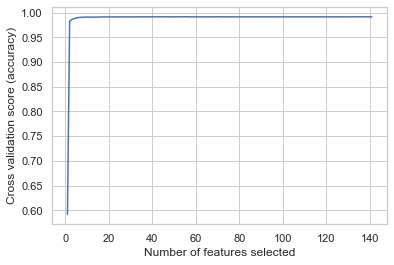

Optimal number of features : 71
Calibration time 1174 s
Saving Model


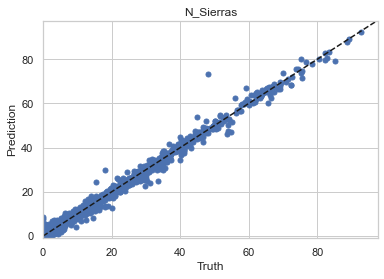

N_Sierras RMSE: 1.35
S_Sierras_High :
Best Score: 0.9901650164358096
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_CDEC__FLL', 'SWE_CDEC__WTM', 'SWE_CDEC__DDM', 'SWE_CDEC__UBC', 'elevation_m', 'Lat', 'SWE_CDEC__CHP', 'SWE_CDEC__HVN', 'SWE_CDEC__TUM', 'SWE_CDEC__GNF', 'SWE_CDEC__FDC', 'SWE_CDEC__BCH', 'SWE_CDEC__EBB', 'SWE_CDEC__LVT', 'SWE_CDEC__HNT', 'SWE_CDEC__SIL', 'WYWeek', 'SWE_CDEC__MHP', 'SWE_CDEC__DPO', 'Long', 'SWE_CDEC__BLD', 'SWE_CDEC__CWD', 'SWE_CDEC__TNY', 'SWE_CDEC__RCK', 'SWE_CDEC__UTY', 'SWE_CDEC__GIN', 'SWE_CDEC__WWC', 'SWE_CDEC__PSC', 'SWE_CDEC__GNL', 'northness', 'SWE_CDEC__SWM', 'SWE_CDEC__MTM', 'SWE_CDEC__RBP', 'SWE_CDEC__SPS', 'SWE_CDEC__BCB', 'SWE_CDEC__CSV', 'SWE_CDEC__GEM', 'prev_SWE', 'Delta_SWE_CDEC__WTM', 'Delta_SWE_CDEC__PDS', 'Delta_SWE_CDEC__DAN', 'Delta_SWE_CDEC__DPO', 'Delta_SWE_CDEC__LVT', 'Delta_SWE_CDEC__CWD', 'Delta_SWE_CDEC__EP5', 'Delta_SWE_CDEC__MTM', 

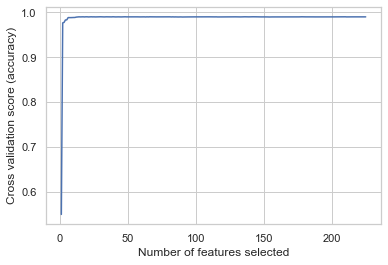

Optimal number of features : 52
Calibration time 2103 s
Saving Model


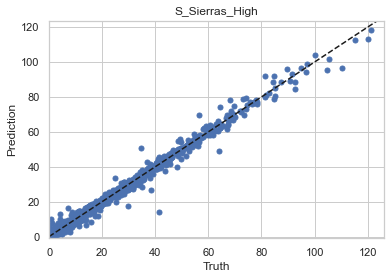

S_Sierras_High RMSE: 1.707
S_Sierras_Low :
Best Score: 0.9900317290625786
Best Params: {'learning_rate': 0.1, 'max_depth': 19, 'n_estimators': 600, 'num_leaves': 25, 'subsample': 0.7}
The optimal features are:  ['SWE_CDEC__FLL', 'SWE_CDEC__TMR', 'SWE_CDEC__WTM', 'SWE_CDEC__DDM', 'Prev_SWE_CDEC__PDS', 'SWE_CDEC__UBC', 'elevation_m', 'Lat', 'SWE_CDEC__CHP', 'SWE_CDEC__TUM', 'SWE_CDEC__GNF', 'SWE_CDEC__CXS', 'SWE_CDEC__FDC', 'SWE_CDEC__BCH', 'SWE_CDEC__LVT', 'WYWeek', 'SWE_CDEC__DPO', 'Long', 'SWE_CDEC__BLD', 'Prev_SWE_CDEC__SIL', 'SWE_CDEC__CWD', 'SWE_CDEC__BSK', 'Prev_SWE_CDEC__MTM', 'SWE_CDEC__TNY', 'SWE_CDEC__BLS', 'SWE_CDEC__RCK', 'SWE_SNOTEL__778_CA_SNTL', 'SWE_CDEC__UTY', 'SWE_CDEC__GIN', 'SWE_CDEC__PSC', 'northness', 'SWE_CDEC__MTM', 'SWE_CDEC__RBP', 'SWE_CDEC__SPS', 'SWE_CDEC__BIM', 'SWE_CDEC__CSV', 'prev_SWE', 'Delta_SWE_CDEC__WTM', 'Delta_SWE_CDEC__PDS', 'Delta_SWE_CDEC__GNF', 'Delta_SWE_CDEC__DAN', 'Delta_SWE_CDEC__VVL', 'Delta_SWE_CDEC__DPO', 'Delta_SWE_CDEC__LVT', 'Delta_SWE

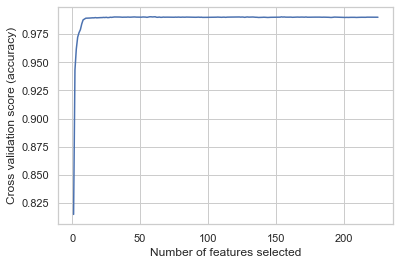

Optimal number of features : 61
Calibration time 2427 s
Saving Model


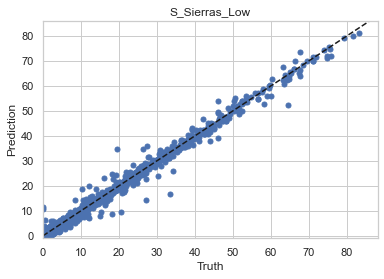

S_Sierras_Low RMSE: 1.356
Greater_Yellowstone :
Best Score: 0.9944131531108343
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__497_WY_SNTL', 'elevation_m', 'SWE_SNOTEL__512_WY_SNTL', 'Lat', 'SWE_SNOTEL__499_WY_SNTL', 'SWE_SNOTEL__377_WY_SNTL', 'Prev_SWE_SNOTEL__862_MT_SNTL', 'SWE_SNOTEL__837_WY_SNTL', 'SWE_SNOTEL__878_WY_SNTL', 'SWE_SNOTEL__683_WY_SNTL', 'SWE_SNOTEL__1131_WY_SNTL', 'SWE_SNOTEL__342_WY_SNTL', 'SWE_SNOTEL__764_WY_SNTL', 'WYWeek', 'SWE_SNOTEL__826_WY_SNTL', 'Long', 'SWE_SNOTEL__325_WY_SNTL', 'SWE_SNOTEL__326_WY_SNTL', 'SWE_SNOTEL__819_WY_SNTL', 'SWE_SNOTEL__751_WY_SNTL', 'SWE_SNOTEL__818_WY_SNTL', 'SWE_SNOTEL__407_MT_SNTL', 'SWE_SNOTEL__754_MT_SNTL', 'northness', 'SWE_SNOTEL__379_WY_SNTL', 'SWE_SNOTEL__786_WY_SNTL', 'SWE_SNOTEL__798_WY_SNTL', 'SWE_SNOTEL__779_WY_SNTL', 'SWE_SNOTEL__1105_MT_SNTL', 'SWE_SNOTEL__1082_WY_SNTL', 'SWE_SNOTEL__923_WY_SNTL', 'SWE_SNOTEL__69

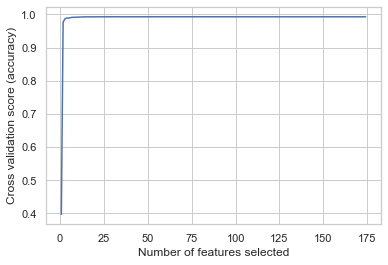

Optimal number of features : 58
Calibration time 1572 s
Saving Model


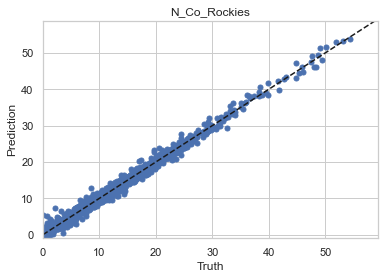

N_Co_Rockies RMSE: 0.6
SW_Mont :
Best Score: 0.9936088335216413
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__424_ID_SNTL', 'SWE_SNOTEL__328_MT_SNTL', 'SWE_SNOTEL__347_MT_SNTL', 'Prev_SWE_SNOTEL__603_MT_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__770_ID_SNTL', 'SWE_SNOTEL__741_ID_SNTL', 'SWE_SNOTEL__749_ID_SNTL', 'SWE_SNOTEL__590_MT_SNTL', 'SWE_SNOTEL__568_MT_SNTL', 'SWE_SNOTEL__403_MT_SNTL', 'WYWeek', 'SWE_SNOTEL__761_ID_SNTL', 'Long', 'SWE_SNOTEL__603_MT_SNTL', 'SWE_SNOTEL__924_MT_SNTL', 'SWE_SNOTEL__385_MT_SNTL', 'Prev_SWE_SNOTEL__347_MT_SNTL', 'northness', 'SWE_SNOTEL__448_MT_SNTL', 'SWE_SNOTEL__858_MT_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__603_MT_SNTL', 'Delta_SWE_SNOTEL__924_MT_SNTL', 'Delta_SWE_SNOTEL__403_MT_SNTL', 'Delta_SWE_SNOTEL__424_ID_SNTL', 'Delta_SWE_SNOTEL__741_ID_SNTL', 'Delta_SWE_SNOTEL__761_ID_SNTL', 'Delta_SWE_SNOTEL__385_MT_SNTL', 'Delta_SWE_SNOTEL__328_MT_SNTL', 

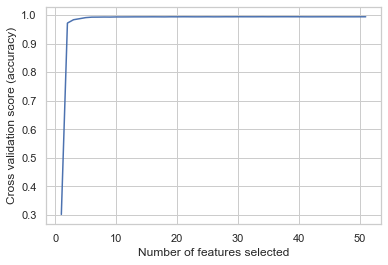

Optimal number of features : 34
Calibration time 262 s
Saving Model


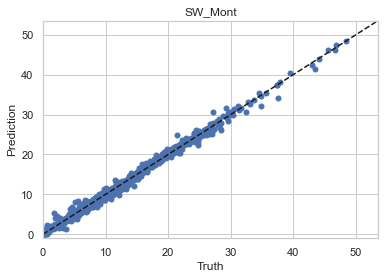

SW_Mont RMSE: 0.579
SW_Co_Rockies :
Best Score: 0.9918828012527758
Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__797_CO_SNTL', 'Prev_SWE_SNOTEL__1185_CO_SNTL', 'SWE_SNOTEL__874_CO_SNTL', 'SWE_SNOTEL__465_CO_SNTL', 'SWE_SNOTEL__780_CO_SNTL', 'SWE_SNOTEL__839_CO_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__1124_CO_SNTL', 'SWE_SNOTEL__1128_CO_SNTL', 'SWE_SNOTEL__713_CO_SNTL', 'SWE_SNOTEL__431_CO_SNTL', 'SWE_SNOTEL__905_CO_SNTL', 'SWE_SNOTEL__1185_CO_SNTL', 'SWE_SNOTEL__762_CO_SNTL', 'WYWeek', 'SWE_SNOTEL__840_CO_SNTL', 'SWE_SNOTEL__1058_CO_SNTL', 'Long', 'SWE_SNOTEL__387_CO_SNTL', 'SWE_SNOTEL__629_CO_SNTL', 'northness', 'prev_SWE', 'Delta_SWE_SNOTEL__1185_CO_SNTL', 'Delta_SWE_SNOTEL__905_CO_SNTL', 'Delta_SWE_SNOTEL__797_CO_SNTL', 'Delta_SWE_SNOTEL__874_CO_SNTL', 'Delta_SWE_SNOTEL__580_CO_SNTL', 'Delta_SWE_SNOTEL__780_CO_SNTL', 'Delta_SWE_SNOTEL__431_CO_SNTL', 'Delta_SWE_SNOTEL__386_CO_SNT

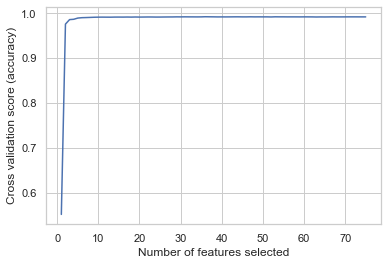

Optimal number of features : 36
Calibration time 406 s
Saving Model


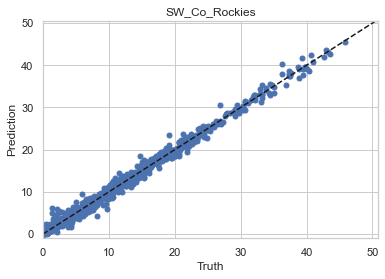

SW_Co_Rockies RMSE: 0.7
GBasin :
Best Score: 0.988611689692285
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__334_NV_SNTL', 'Prev_SWE_SNOTEL__1247_UT_SNTL', 'SWE_SNOTEL__794_OR_SNTL', 'Prev_SWE_SNOTEL__583_UT_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__1272_NV_SNTL', 'SWE_SNOTEL__1150_NV_SNTL', 'SWE_SNOTEL__1146_UT_SNTL', 'SWE_SNOTEL__570_NV_SNTL', 'SWE_SNOTEL__373_NV_SNTL', 'SWE_SNOTEL__1195_NV_SNTL', 'Prev_SWE_SNOTEL__1214_UT_SNTL', 'Prev_SWE_SNOTEL__477_OR_SNTL', 'SWE_SNOTEL__1010_OR_SNTL', 'Prev_SWE_SNOTEL__723_UT_SNTL', 'SWE_SNOTEL__1155_NV_SNTL', 'Prev_SWE_SNOTEL__334_NV_SNTL', 'SWE_SNOTEL__1065_UT_SNTL', 'SWE_SNOTEL__1066_UT_SNTL', 'SWE_SNOTEL__1214_UT_SNTL', 'Prev_SWE_SNOTEL__498_NV_SNTL', 'Prev_SWE_SNOTEL__677_ID_SNTL', 'SWE_SNOTEL__503_NV_SNTL', 'SWE_SNOTEL__1110_NV_SNTL', 'SWE_SNOTEL__476_NV_SNTL', 'SWE_SNOTEL__849_NV_SNTL', 'SWE_SNOTEL__677_ID_SNTL', 'Prev_SWE_SNOTEL__1147_

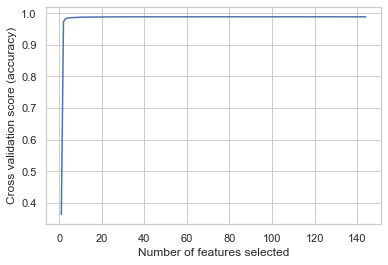

Optimal number of features : 109
Calibration time 981 s
Saving Model


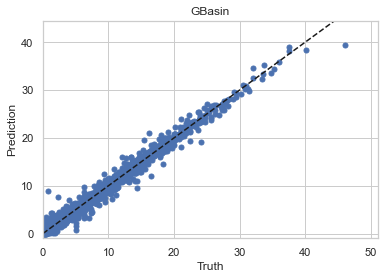

GBasin RMSE: 0.682
N_Wasatch :
Best Score: 0.9937604856860391
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__1225_UT_SNTL', 'Prev_SWE_SNOTEL__521_UT_SNTL', 'Prev_SWE_SNOTEL__528_UT_SNTL', 'SWE_SNOTEL__1192_UT_SNTL', 'elevation_m', 'Lat', 'Prev_SWE_SNOTEL__330_UT_SNTL', 'Prev_SWE_SNOTEL__1054_UT_SNTL', 'SWE_SNOTEL__765_WY_SNTL', 'SWE_SNOTEL__1114_UT_SNTL', 'SWE_SNOTEL__763_UT_SNTL', 'Prev_SWE_SNOTEL__566_UT_SNTL', 'Prev_SWE_SNOTEL__582_UT_SNTL', 'Prev_SWE_SNOTEL__596_UT_SNTL', 'SWE_SNOTEL__484_ID_SNTL', 'Prev_SWE_SNOTEL__559_UT_SNTL', 'SWE_SNOTEL__332_UT_SNTL', 'SWE_SNOTEL__393_UT_SNTL', 'SWE_SNOTEL__1162_UT_SNTL', 'Prev_SWE_SNOTEL__1135_UT_SNTL', 'SWE_SNOTEL__366_UT_SNTL', 'Prev_SWE_SNOTEL__1098_UT_SNTL', 'SWE_SNOTEL__1113_UT_SNTL', 'SWE_SNOTEL__833_UT_SNTL', 'SWE_SNOTEL__481_UT_SNTL', 'SWE_SNOTEL__333_UT_SNTL', 'SWE_SNOTEL__455_UT_SNTL', 'SWE_SNOTEL__554_WY_SNTL', 'SWE_SNOTEL__509_W

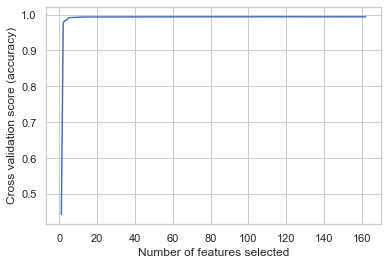

Optimal number of features : 112
Calibration time 1273 s
Saving Model


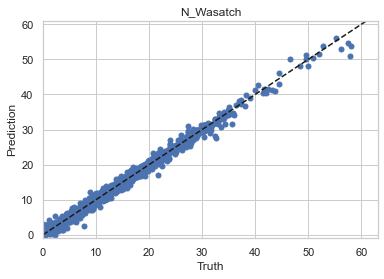

N_Wasatch RMSE: 0.64
N_Cascade :
Best Score: 0.9963445651770529
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 25, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__863_WA_SNTL', 'SWE_SNOTEL__804_WA_SNTL', 'SWE_SNOTEL__1012_WA_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__777_WA_SNTL', 'SWE_SNOTEL__791_WA_SNTL', 'SWE_SNOTEL__728_WA_SNTL', 'SWE_SNOTEL__975_WA_SNTL', 'SWE_SNOTEL__1171_WA_SNTL', 'SWE_SNOTEL__941_WA_SNTL', 'WYWeek', 'SWE_SNOTEL__748_WA_SNTL', 'Long', 'SWE_SNOTEL__672_WA_SNTL', 'SWE_SNOTEL__832_WA_SNTL', 'SWE_SNOTEL__990_WA_SNTL', 'SWE_SNOTEL__681_WA_SNTL', 'SWE_SNOTEL__909_WA_SNTL', 'SWE_SNOTEL__702_WA_SNTL', 'SWE_SNOTEL__942_WA_SNTL', 'SWE_SNOTEL__998_WA_SNTL', 'SWE_SNOTEL__699_WA_SNTL', 'northness', 'SWE_SNOTEL__1104_WA_SNTL', 'SWE_SNOTEL__912_WA_SNTL', 'SWE_SNOTEL__642_WA_SNTL', 'SWE_SNOTEL__418_WA_SNTL', 'SWE_SNOTEL__606_WA_SNTL', 'SWE_SNOTEL__1259_WA_SNTL', 'Prev_SWE_SNOTEL__998_WA_SNTL', 'SWE_SNOTEL__1011_WA_SNTL', 'p

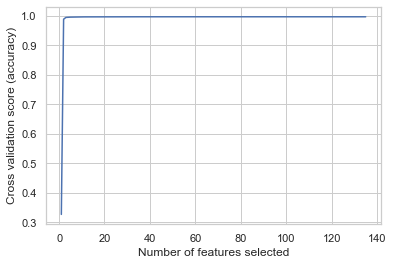

Optimal number of features : 51
Calibration time 1247 s
Saving Model


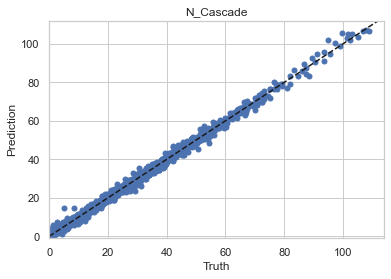

N_Cascade RMSE: 1.043
S_Wasatch :
Best Score: 0.9909624873507072
Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__1216_UT_SNTL', 'Prev_SWE_SNOTEL__514_UT_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__612_UT_SNTL', 'SWE_SNOTEL__1154_UT_SNTL', 'Prev_SWE_SNOTEL__1261_UT_SNTL', 'SWE_SNOTEL__1269_UT_SNTL', 'SWE_SNOTEL__339_UT_SNTL', 'Prev_SWE_SNOTEL__1222_UT_SNTL', 'SWE_SNOTEL__1278_UT_SNTL', 'Prev_SWE_SNOTEL__1248_UT_SNTL', 'Prev_SWE_SNOTEL__1215_UT_SNTL', 'Prev_SWE_SNOTEL__1156_UT_SNTL', 'Prev_SWE_SNOTEL__714_UT_SNTL', 'Prev_SWE_SNOTEL__475_UT_SNTL', 'SWE_SNOTEL__1226_UT_SNTL', 'Prev_SWE_SNOTEL__329_UT_SNTL', 'Prev_SWE_SNOTEL__742_UT_SNTL', 'Prev_SWE_SNOTEL__1278_UT_SNTL', 'SWE_SNOTEL__1197_UT_SNTL', 'Prev_SWE_SNOTEL__1197_UT_SNTL', 'SWE_SNOTEL__621_UT_SNTL', 'SWE_SNOTEL__452_UT_SNTL', 'Prev_SWE_SNOTEL__1226_UT_SNTL', 'Prev_SWE_SNOTEL__1148_UT_SNTL', 'SWE_SNOTEL__1222_UT_SNTL', 'SWE_SNOTEL__1

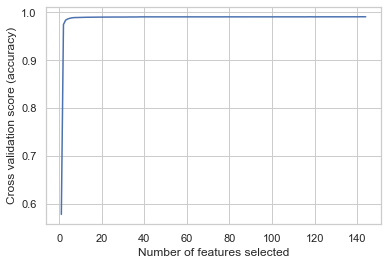

Optimal number of features : 142
Calibration time 918 s
Saving Model


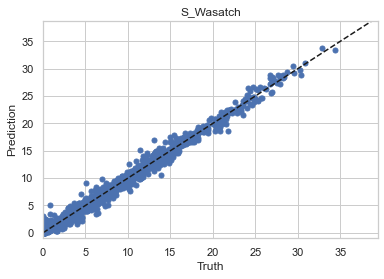

S_Wasatch RMSE: 0.559
SW_Mtns :
Best Score: 0.9807847579241834
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__1271_AZ_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__927_AZ_SNTL', 'SWE_SNOTEL__308_AZ_SNTL', 'SWE_SNOTEL__1271_AZ_SNTL', 'Prev_SWE_SNOTEL__1140_AZ_SNTL', 'SWE_SNOTEL__902_AZ_SNTL', 'SWE_SNOTEL__757_NM_SNTL', 'WYWeek', 'Long', 'SWE_SNOTEL__1048_NM_SNTL', 'SWE_SNOTEL__617_AZ_SNTL', 'Prev_SWE_SNOTEL__927_AZ_SNTL', 'SWE_SNOTEL__1140_AZ_SNTL', 'SWE_SNOTEL__1121_AZ_SNTL', 'northness', 'prev_SWE', 'Delta_SWE_SNOTEL__1048_NM_SNTL', 'Delta_SWE_SNOTEL__488_AZ_SNTL', 'Delta_SWE_SNOTEL__877_AZ_SNTL', 'Delta_SWE_SNOTEL__927_AZ_SNTL', 'Delta_SWE_SNOTEL__1143_AZ_SNTL']


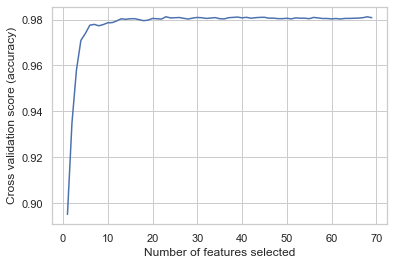

Optimal number of features : 23
Calibration time 244 s
Saving Model


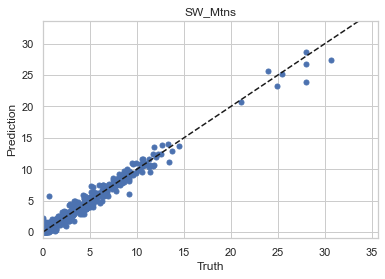

SW_Mtns RMSE: 0.427
E_WA_N_Id_W_Mont :
Best Score: 0.9958423473140758
Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__311_MT_SNTL', 'SWE_SNOTEL__510_MT_SNTL', 'SWE_SNOTEL__918_MT_SNTL', 'Prev_SWE_SNOTEL__988_ID_SNTL', 'SWE_SNOTEL__600_ID_SNTL', 'SWE_SNOTEL__530_MT_SNTL', 'SWE_SNOTEL__1053_ID_SNTL', 'SWE_SNOTEL__644_WA_SNTL', 'SWE_SNOTEL__1159_WA_SNTL', 'elevation_m', 'SWE_SNOTEL__376_WA_SNTL', 'Lat', 'Prev_SWE_SNOTEL__411_ID_SNTL', 'SWE_SNOTEL__535_ID_SNTL', 'SWE_SNOTEL__588_ID_SNTL', 'SWE_SNOTEL__411_ID_SNTL', 'SWE_SNOTEL__645_ID_SNTL', 'SWE_SNOTEL__466_ID_SNTL', 'SWE_SNOTEL__988_ID_SNTL', 'Prev_SWE_SNOTEL__984_WA_SNTL', 'SWE_SNOTEL__1043_WA_SNTL', 'SWE_SNOTEL__623_ID_SNTL', 'Prev_SWE_SNOTEL__824_WA_SNTL', 'SWE_SNOTEL__738_ID_SNTL', 'SWE_SNOTEL__500_MT_SNTL', 'SWE_SNOTEL__787_MT_SNTL', 'WYWeek', 'Long', 'Prev_SWE_SNOTEL__787_MT_SNTL', 'SWE_SNOTEL__989_ID_SNTL', 'SWE_SNOTEL__803_ID_SN

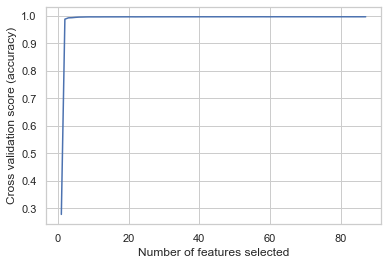

Optimal number of features : 63
Calibration time 515 s
Saving Model


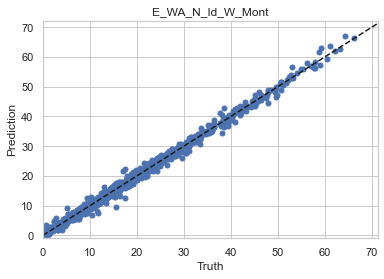

E_WA_N_Id_W_Mont RMSE: 0.81
S_Wyoming :
Best Score: 0.9934410688342824
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__872_WY_SNTL', 'SWE_SNOTEL__1015_WY_SNTL', 'Prev_SWE_SNOTEL__1196_WY_SNTL', 'SWE_SNOTEL__1196_WY_SNTL', 'SWE_SNOTEL__872_WY_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__1046_WY_SNTL', 'Prev_SWE_SNOTEL__1046_WY_SNTL', 'SWE_SNOTEL__732_WY_SNTL', 'WYWeek', 'SWE_SNOTEL__571_WY_SNTL', 'Long', 'SWE_SNOTEL__449_WY_SNTL', 'SWE_SNOTEL__317_WY_SNTL', 'SWE_SNOTEL__852_WY_SNTL', 'Prev_SWE_SNOTEL__731_WY_SNTL', 'SWE_SNOTEL__731_WY_SNTL', 'SWE_SNOTEL__673_WY_SNTL', 'SWE_SNOTEL__1045_WY_SNTL', 'SWE_SNOTEL__389_WY_SNTL', 'northness', 'SWE_SNOTEL__1119_WY_SNTL', 'SWE_SNOTEL__859_WY_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__389_WY_SNTL', 'Delta_SWE_SNOTEL__732_WY_SNTL', 'Delta_SWE_SNOTEL__1196_WY_SNTL', 'Delta_SWE_SNOTEL__859_WY_SNTL', 'Delta_SWE_SNOTEL__673_WY_SNTL', 'Delta_SWE_SNOTEL__1

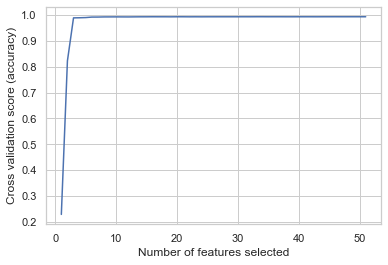

Optimal number of features : 34
Calibration time 242 s
Saving Model


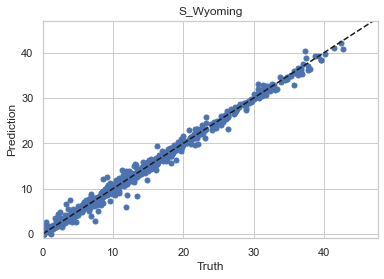

S_Wyoming RMSE: 0.758
SE_Co_Rockies :
Best Score: 0.9861674548894952
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__665_NM_SNTL', 'Prev_SWE_SNOTEL__430_CO_SNTL', 'Prev_SWE_SNOTEL__303_CO_SNTL', 'SWE_SNOTEL__854_NM_SNTL', 'SWE_SNOTEL__1017_NM_SNTL', 'SWE_SNOTEL__1005_CO_SNTL', 'elevation_m', 'SWE_SNOTEL__1172_NM_SNTL', 'Lat', 'SWE_SNOTEL__1254_NM_SNTL', 'Prev_SWE_SNOTEL__854_NM_SNTL', 'SWE_SNOTEL__1168_NM_SNTL', 'SWE_SNOTEL__773_CO_SNTL', 'SWE_SNOTEL__1170_NM_SNTL', 'SWE_SNOTEL__857_CO_SNTL', 'SWE_SNOTEL__303_CO_SNTL', 'WYWeek', 'SWE_SNOTEL__922_NM_SNTL', 'Long', 'Prev_SWE_SNOTEL__773_CO_SNTL', 'Prev_SWE_SNOTEL__922_NM_SNTL', 'SWE_SNOTEL__708_NM_SNTL', 'SWE_SNOTEL__491_NM_SNTL', 'SWE_SNOTEL__316_NM_SNTL', 'Prev_SWE_SNOTEL__1168_NM_SNTL', 'SWE_SNOTEL__532_NM_SNTL', 'SWE_SNOTEL__430_CO_SNTL', 'SWE_SNOTEL__744_NM_SNTL', 'SWE_SNOTEL__921_NM_SNTL', 'SWE_SNOTEL__715_NM_SNTL', 'Prev_SWE_SNOT

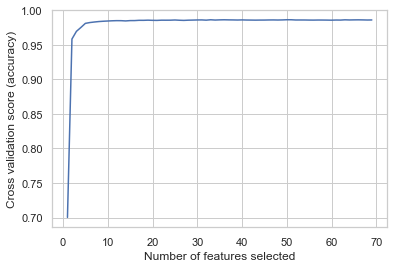

Optimal number of features : 50
Calibration time 294 s
Saving Model


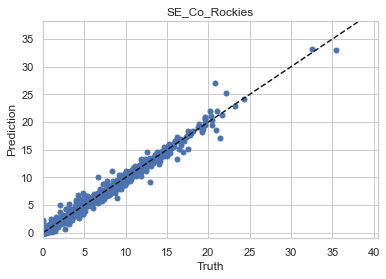

SE_Co_Rockies RMSE: 0.547
Sawtooth :
Best Score: 0.995304661938065
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 25, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__490_ID_SNTL', 'Prev_SWE_SNOTEL__835_MT_SNTL', 'Prev_SWE_SNOTEL__338_ID_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__450_ID_SNTL', 'SWE_SNOTEL__433_MT_SNTL', 'Prev_SWE_SNOTEL__747_ID_SNTL', 'Prev_SWE_SNOTEL__436_MT_SNTL', 'SWE_SNOTEL__1287_MT_SNTL', 'SWE_SNOTEL__370_ID_SNTL', 'SWE_SNOTEL__489_ID_SNTL', 'SWE_SNOTEL__319_ID_SNTL', 'SWE_SNOTEL__524_ID_SNTL', 'SWE_SNOTEL__576_MT_SNTL', 'Prev_SWE_SNOTEL__524_ID_SNTL', 'SWE_SNOTEL__355_MT_SNTL', 'Prev_SWE_SNOTEL__627_ID_SNTL', 'SWE_SNOTEL__930_MT_SNTL', 'SWE_SNOTEL__704_ID_SNTL', 'SWE_SNOTEL__436_MT_SNTL', 'SWE_SNOTEL__312_ID_SNTL', 'SWE_SNOTEL__313_MT_SNTL', 'WYWeek', 'Long', 'SWE_SNOTEL__792_ID_SNTL', 'SWE_SNOTEL__830_ID_SNTL', 'SWE_SNOTEL__805_ID_SNTL', 'SWE_SNOTEL__835_MT_SNTL', 'SWE_SNOTEL__338_ID_SNTL', 'SWE_SNOTEL__845_ID_SNT

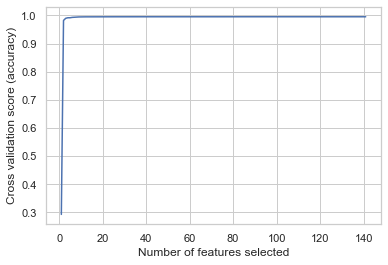

Optimal number of features : 96
Calibration time 1212 s
Saving Model


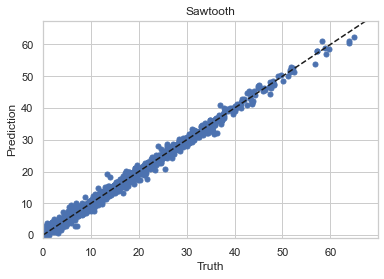

Sawtooth RMSE: 0.715
Ca_Coast :
Best Score: 0.9358712638892153
Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 5, 'subsample': 0.7}
The optimal features are:  ['SWE_CDEC__PET', 'Prev_SWE_CDEC__BFL', 'WYWeek', 'SWE_CDEC__SHM', 'SWE_CDEC__BFL', 'Long', 'elevation_m', 'SWE_CDEC__SCT', 'Lat', 'SWE_CDEC__BNK', 'prev_SWE', 'Delta_SWE_CDEC__PET', 'Delta_SWE_CDEC__BNK', 'Delta_SWE_CDEC__RRM', 'Delta_SWE_CDEC__SHM']


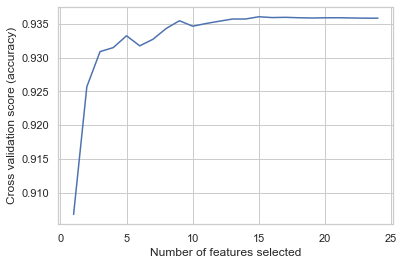

Optimal number of features : 15
Calibration time 90 s
Saving Model


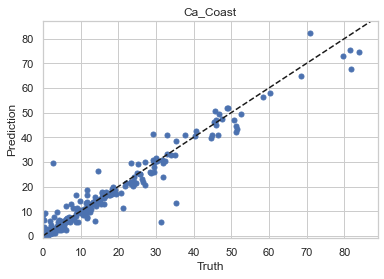

Ca_Coast RMSE: 3.367
E_Or :
Best Score: 0.9930984842332828
Best Params: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__422_OR_SNTL', 'SWE_SNOTEL__1231_WA_SNTL', 'Prev_SWE_SNOTEL__767_OR_SNTL', 'Prev_SWE_SNOTEL__1129_WA_SNTL', 'SWE_SNOTEL__470_OR_SNTL', 'SWE_SNOTEL__563_OR_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__736_OR_SNTL', 'Prev_SWE_SNOTEL__1079_OR_SNTL', 'SWE_SNOTEL__1129_WA_SNTL', 'SWE_SNOTEL__647_OR_SNTL', 'SWE_SNOTEL__331_OR_SNTL', 'SWE_SNOTEL__873_OR_SNTL', 'SWE_SNOTEL__302_OR_SNTL', 'SWE_SNOTEL__812_OR_SNTL', 'SWE_SNOTEL__523_OR_SNTL', 'WYWeek', 'SWE_SNOTEL__1079_OR_SNTL', 'Long', 'Prev_SWE_SNOTEL__647_OR_SNTL', 'SWE_SNOTEL__767_OR_SNTL', 'SWE_SNOTEL__494_OR_SNTL', 'northness', 'SWE_SNOTEL__304_OR_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__767_OR_SNTL', 'Delta_SWE_SNOTEL__736_OR_SNTL', 'Delta_SWE_SNOTEL__1129_WA_SNTL', 'Delta_SWE_SNOTEL__304_OR_SNTL', 'Delta_SWE_SNOTEL__563_OR_SNTL', 'Delta_

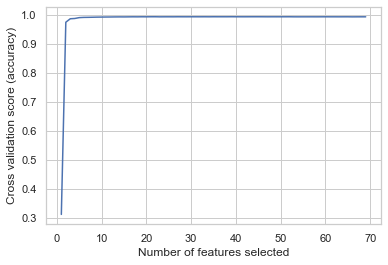

Optimal number of features : 39
Calibration time 364 s
Saving Model


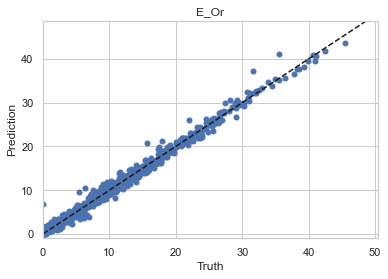

E_Or RMSE: 0.681
N_Yellowstone :
Best Score: 0.9899402875243718
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['SWE_SNOTEL__365_MT_SNTL', 'Prev_SWE_SNOTEL__1009_MT_SNTL', 'SWE_SNOTEL__1009_MT_SNTL', 'Prev_SWE_SNOTEL__919_MT_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__487_MT_SNTL', 'SWE_SNOTEL__929_MT_SNTL', 'WYWeek', 'SWE_SNOTEL__917_MT_SNTL', 'SWE_SNOTEL__700_MT_SNTL', 'Long', 'SWE_SNOTEL__360_MT_SNTL', 'SWE_SNOTEL__690_MT_SNTL', 'Prev_SWE_SNOTEL__365_MT_SNTL', 'SWE_SNOTEL__437_MT_SNTL', 'SWE_SNOTEL__919_MT_SNTL', 'northness', 'SWE_SNOTEL__781_MT_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__1009_MT_SNTL', 'Delta_SWE_SNOTEL__700_MT_SNTL', 'Delta_SWE_SNOTEL__917_MT_SNTL', 'Delta_SWE_SNOTEL__690_MT_SNTL', 'Delta_SWE_SNOTEL__929_MT_SNTL', 'Delta_SWE_SNOTEL__360_MT_SNTL', 'Delta_SWE_SNOTEL__365_MT_SNTL', 'Delta_SWE_SNOTEL__781_MT_SNTL']


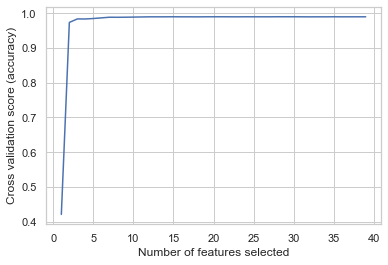

Optimal number of features : 28
Calibration time 169 s
Saving Model


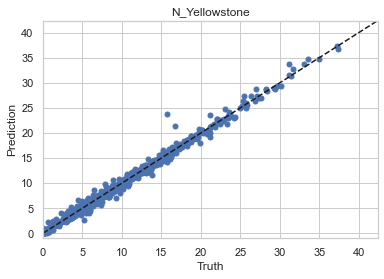

N_Yellowstone RMSE: 0.615
S_Cascade :
Best Score: 0.994928464185605
Best Params: {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__1167_OR_SNTL', 'SWE_SNOTEL__406_OR_SNTL', 'Prev_SWE_SNOTEL__801_OR_SNTL', 'SWE_SNOTEL__344_OR_SNTL', 'SWE_SNOTEL__945_OR_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__483_OR_SNTL', 'SWE_SNOTEL__1077_OR_SNTL', 'SWE_SNOTEL__529_OR_SNTL', 'SWE_SNOTEL__1166_OR_SNTL', 'SWE_SNOTEL__925_OR_SNTL', 'SWE_SNOTEL__655_OR_SNTL', 'SWE_SNOTEL__1000_OR_SNTL', 'SWE_SNOTEL__434_OR_SNTL', 'SWE_SNOTEL__398_OR_SNTL', 'SWE_SNOTEL__1167_OR_SNTL', 'WYWeek', 'SWE_SNOTEL__756_OR_SNTL', 'SWE_SNOTEL__526_OR_SNTL', 'Long', 'SWE_SNOTEL__815_OR_SNTL', 'Prev_SWE_SNOTEL__712_OR_SNTL', 'SWE_SNOTEL__651_OR_SNTL', 'SWE_SNOTEL__666_OR_SNTL', 'northness', 'SWE_SNOTEL__619_OR_SNTL', 'SWE_SNOTEL__801_OR_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__1167_OR_SNTL', 'Delta_SWE_SNOTEL__529_OR_SNTL', 'Delta_SWE_SNOTEL__61

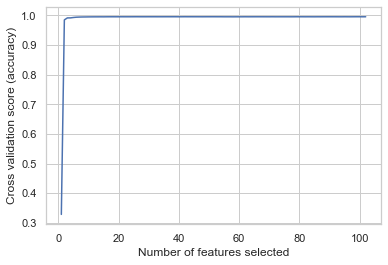

Optimal number of features : 42
Calibration time 699 s
Saving Model


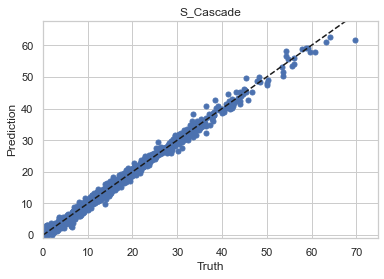

S_Cascade RMSE: 0.764
Wa_Coast :
Best Score: 0.993147330646498
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__1107_WA_SNTL', 'Prev_SWE_SNOTEL__648_WA_SNTL', 'SWE_SNOTEL__1107_WA_SNTL', 'WYWeek', 'SWE_SNOTEL__974_WA_SNTL', 'Long', 'northness', 'Prev_SWE_SNOTEL__974_WA_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__648_WA_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__1107_WA_SNTL', 'Delta_SWE_SNOTEL__648_WA_SNTL', 'Delta_SWE_SNOTEL__974_WA_SNTL']


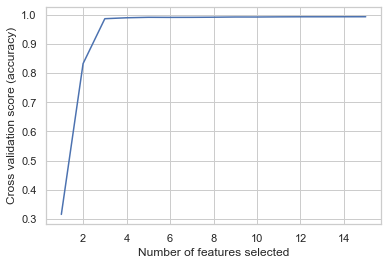

Optimal number of features : 15
Calibration time 36 s
Saving Model


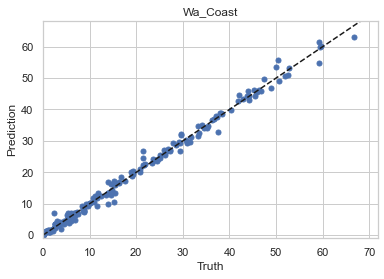

Wa_Coast RMSE: 1.329
Greater_Glacier :
Best Score: 0.9943388782570244
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__657_MT_SNTL', 'SWE_SNOTEL__664_MT_SNTL', 'Prev_SWE_SNOTEL__646_MT_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__482_MT_SNTL', 'SWE_SNOTEL__667_MT_SNTL', 'SWE_SNOTEL__901_MT_SNTL', 'SWE_SNOTEL__562_MT_SNTL', 'WYWeek', 'Long', 'SWE_SNOTEL__613_MT_SNTL', 'SWE_SNOTEL__414_MT_SNTL', 'SWE_SNOTEL__693_MT_SNTL', 'SWE_SNOTEL__646_MT_SNTL', 'northness', 'prev_SWE', 'Delta_SWE_SNOTEL__646_MT_SNTL', 'Delta_SWE_SNOTEL__649_MT_SNTL', 'Delta_SWE_SNOTEL__667_MT_SNTL', 'Delta_SWE_SNOTEL__613_MT_SNTL', 'Delta_SWE_SNOTEL__664_MT_SNTL', 'Delta_SWE_SNOTEL__693_MT_SNTL', 'Delta_SWE_SNOTEL__482_MT_SNTL', 'Delta_SWE_SNOTEL__414_MT_SNTL']


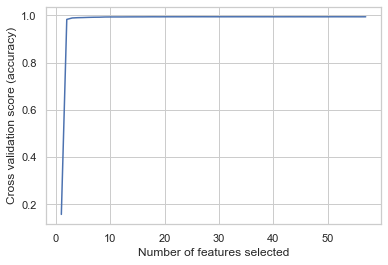

Optimal number of features : 25
Calibration time 292 s
Saving Model


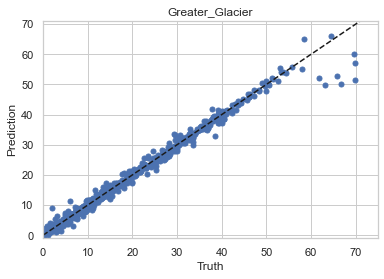

Greater_Glacier RMSE: 1.479
Or_Coast :
Best Score: 0.9756805720421952
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600, 'num_leaves': 15, 'subsample': 0.7}
The optimal features are:  ['Prev_SWE_SNOTEL__743_OR_SNTL', 'SWE_SNOTEL__1084_OR_SNTL', 'WYWeek', 'SWE_SNOTEL__341_OR_SNTL', 'SWE_SNOTEL__558_OR_SNTL', 'Prev_SWE_SNOTEL__558_OR_SNTL', 'Prev_SWE_SNOTEL__1084_OR_SNTL', 'SWE_SNOTEL__726_OR_SNTL', 'Long', 'northness', 'Prev_SWE_SNOTEL__341_OR_SNTL', 'Prev_SWE_SNOTEL__726_OR_SNTL', 'elevation_m', 'Lat', 'SWE_SNOTEL__743_OR_SNTL', 'prev_SWE', 'Delta_SWE_SNOTEL__743_OR_SNTL', 'Delta_SWE_SNOTEL__558_OR_SNTL', 'Delta_SWE_SNOTEL__341_OR_SNTL', 'Delta_SWE_SNOTEL__726_OR_SNTL']


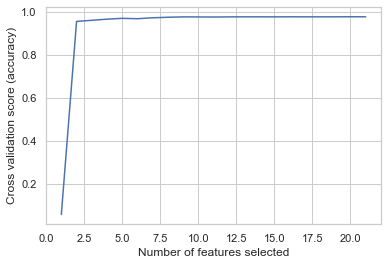

Optimal number of features : 20
Calibration time 49 s
Saving Model


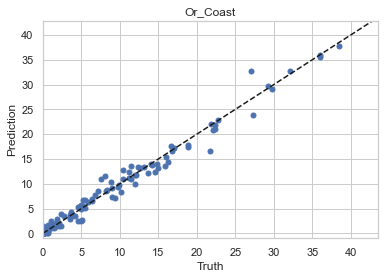

Or_Coast RMSE: 0.813
CPU times: user 17h 41min 10s, sys: 18min 56s, total: 18h 6s
Wall time: 5h 3min 17s


In [116]:
%%time
splits_LGBM , preds_LGBM = Batch_Train('SWE', RegionTrain, LGBMRegressor, LGBM_param_grid, Region_list)

In [117]:
#### Evaluate RMSE
RMSE_dict_lgbm={}
lgbm_rmse_df= pd.DataFrame()
for region in Region_list:
    rmse = mean_squared_error(splits_LGBM.get(region)[3], preds_LGBM.get(region), squared=False)
    print(region, "RMSE:", (round(rmse,3)))
    RMSE_dict_lgbm[region]=rmse

### Calc Weighted RMSE
Total_RMSE = mean_squared_error(all_preds_df['y_test'], all_preds_df['y_pred'], squared = False)
print('weighted RMSE:', round(Total_RMSE, 3))

N_Sierras RMSE: 1.35
S_Sierras_High RMSE: 1.707
S_Sierras_Low RMSE: 1.356
Greater_Yellowstone RMSE: 0.637
N_Co_Rockies RMSE: 0.6
SW_Mont RMSE: 0.579
SW_Co_Rockies RMSE: 0.7
GBasin RMSE: 0.682
N_Wasatch RMSE: 0.64
N_Cascade RMSE: 1.043
S_Wasatch RMSE: 0.559
SW_Mtns RMSE: 0.427
E_WA_N_Id_W_Mont RMSE: 0.81
S_Wyoming RMSE: 0.758
SE_Co_Rockies RMSE: 0.547
Sawtooth RMSE: 0.715
Ca_Coast RMSE: 3.367
E_Or RMSE: 0.681
N_Yellowstone RMSE: 0.615
S_Cascade RMSE: 0.764
Wa_Coast RMSE: 1.329
Greater_Glacier RMSE: 1.479
Or_Coast RMSE: 0.813


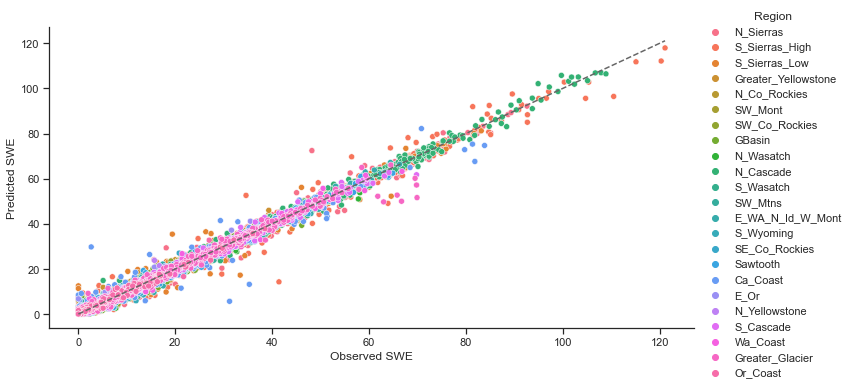

In [118]:
#Plot all region predictions together

sns.set(style='ticks')

SWEmax = max(all_preds_df['y_test'])

sns.relplot(data=all_preds_df, x='y_test', y='y_pred', hue='Region', hue_order=Region_list, aspect=2)
plt.plot([0,SWEmax], [0,SWEmax], color = '.4', linestyle = '--')
# plt.xlim([-1, 1])
# plt.ylim([(prediction_dict.get(region).min()-1),(prediction_dict.get(region).max()+5)])
plt.xlabel('Observed SWE')
plt.ylabel('Predicted SWE')
plt.show()